In [47]:
# Imports

# Data Wrangling
import pandas as pd
import numpy as np

# Plotting Utils
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.cm import ScalarMappable
from IPython.display import display, HTML

# Pipeline Tools
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, mean_squared_error, r2_score


# Models
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR



# FARS Classification

## EDA

In [2]:
fars_raw = pd.read_csv('fars.csv')

print(f'Data set shape: {fars_raw.shape}')

Data set shape: (100968, 30)


The data set is extremely large, containing 30 features for 100,000+ instances of recorded data. Additionally, there are no missing values and only a small portion of the recorded values are 'unknown'. These features are mainly categoric in type. Only 5 out of 30 are quantitative. Several of these categorical data types are of high cardinality, meaning they have 10+ possible categories instances can be. This will require later intervention for some of the pipelines.

In [3]:
quantitative_types = ['int64', 'int32', 'float64', 'float32', 'int16', 'float16']
categorical_types = ['object', 'category', 'bool', 'datetime64[ns]']

def classify_columns(column):

    dtype = column.dtype
    if dtype in quantitative_types:
        return 'Quantitative'
    elif dtype in categorical_types:
        num_unique = column.nunique()
        if num_unique < 10:
            return 'Categorical (L)'
        else:
            return 'Categorical (H)'
    else:
        return 'Other'

column_classification = pd.DataFrame({
    'Column Name': fars_raw.columns,
    'Data Type': fars_raw.dtypes,
    'Category': fars_raw.apply(classify_columns)
})

type_count = column_classification['Category'].value_counts()

print(type_count)

Category
Categorical (L)    13
Categorical (H)    12
Quantitative        5
Name: count, dtype: int64


Most of the injuries recorded in the dataset were fatal (41%) whilst 21% of crashes recorded no injury and the rest had some amount of injury to the person.


In [4]:
injury_count = fars_raw['INJURY_SEVERITY'].value_counts()
injuru_percentages = fars_raw['INJURY_SEVERITY'].value_counts(normalize=True) * 100

injury_summary = pd.DataFrame({
    'Count': injury_count,
    'Percentage (%)': round(injuru_percentages,2)
})

print(injury_summary.to_string())

                                Count  Percentage (%)
INJURY_SEVERITY                                      
Fatal_Injury                    42116           41.71
No_Injury                       20007           19.82
Incapaciting_Injury             15072           14.93
Nonincapaciting_Evident_Injury  13890           13.76
Possible_Injury                  8674            8.59
Unknown                           901            0.89
Injured_Severity_Unknown          299            0.30
Died_Prior_to_Accident              9            0.01


Box plots of the quantitative variables (which can be seen below) reveals that most crashes occurred with a non-zero level of blood alcohol in the persons system. Additionally, around 22,000 of people in the dataset appear to have drugs in their system

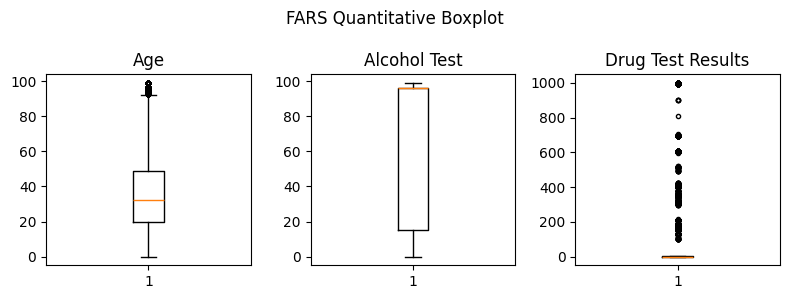

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

axes[0].boxplot(fars_raw['AGE'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[0].set_title('Age')
axes[1].boxplot(fars_raw['ALCOHOL_TEST_RESULT'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[1].set_title('Alcohol Test', )
axes[2].boxplot(fars_raw['DRUG_TEST_RESULTS_(1_of_3)'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[2].set_title('Drug Test Results')

fig.suptitle("FARS Quantitative Boxplot")
plt.tight_layout()

## Data Preparation

'Unknown' instances of the target variable were removed. Additionally, fatalities before crashes were removed as there were very few instances of them.

In [6]:
# Remove any unknown
fars_cleaned = fars_raw[~(fars_raw == 'Unknown').any(axis=1)]
# Remove unknown injury severity
fars_cleaned = fars_cleaned[fars_cleaned['INJURY_SEVERITY'] != 'Possible_Injury']
fars_cleaned = fars_cleaned[fars_cleaned['INJURY_SEVERITY'] != 'Injured_Severity_Unknown']
fars_cleaned = fars_cleaned[fars_cleaned['INJURY_SEVERITY'] != 'Died_Prior_to_Accident']

14 possible predictors were chosen for their intuitive connection to car crashes (such as alcohol blood level). This was done to reduce feature dimensionality.

In [7]:
numeric_cols = ['AGE', 'ALCOHOL_TEST_RESULT', 'DRUG_TEST_RESULTS_(1_of_3)', 'DRUG_TEST_RESULTS_(2_of_3)','DRUG_TEST_RESULTS_(3_of_3)']
selected_features = [ 
    'AGE', 
    'SEX',
    'PERSON_TYPE',
    'SEATING_POSITION',
    'RESTRAINT_SYSTEM-USE',
    'AIR_BAG_AVAILABILITY/DEPLOYMENT',
    'EJECTION',
    'POLICE_REPORTED_ALCOHOL_INVOLVEMENT',
    'POLICE-REPORTED_DRUG_INVOLVEMENT',
    'ALCOHOL_TEST_RESULT',
    'DRUG_TEST_RESULTS_(1_of_3)',
    'DRUG_TEST_RESULTS_(2_of_3)',
    'DRUG_TEST_RESULTS_(3_of_3)',
    'TAKEN_TO_HOSPITAL',
]

target_col = 'INJURY_SEVERITY'
categorical_cols = list(set(selected_features) - set(numeric_cols))

Categoric features were 'one hot encoded' removing the original columns and adding binary ones for each possible category. This was necessary for use within models which work on continuous features otherwise the data stored here would have to be lost.

Continuous variables were normalized, placing the all quantitative features on the same scale allows for them to have an equal impact on models later on. 

The dataset has been under-sampled. Balancing the target classes so that the model trained would not be weighted towards predicting the majority class. This under-sampling should not lead to a decrease in quality as there is an abundance of data present.

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        # Scale continuous variables
        ('num', StandardScaler(), numeric_cols),
        
        # One-hot encode categorical columns
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ],
    remainder='drop'
)

The dataset was split into 80:20 training and testing sub0sets. This allows for robust training of the models as well as a large enough remaining set for reliable evaluation. Stratification has been used to keep class imbalances similar across the sets, ensuring models are fairly trained and tested.

In [9]:
df_model = fars_cleaned[selected_features + [target_col]].copy()

X = df_model[selected_features]
y = df_model[target_col]

# Split test and train keeping target variable proportions
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


## Pipelines

### Decision Tree

RFE was used on the selected features which recursively removes least important features until the desired amount features remain. The impurity reduction each attribute X controntributes to is summed across the tree and used to give each feature an 'importance'. The most important features were then used in the final model (grid search tuning revealed top 10 perform best). This was dome to reduce overfilling, by removing redundant features, and computational complexity for the final model [1]. 

In [13]:
tree_for_rfe = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced')

rfe_step = RFE(
    estimator=tree_for_rfe,
    n_features_to_select=5,
    step=1
)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('rfe', rfe_step),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

Finally, the dataset was partitioned using 5 fold cross validation, allowing for the hyper parameters of the model to be tuned without exposing the model to testing data. The resulting best performing set of parameters were chosen for testing the final mode. This is crucial as tuning of hyper parameters will allow for the model to perform best on the data set. Whilst partitioning allows for these results of each test to not be 'fixed' by the model just overfilling to the testing set.

In [ ]:
param_grid = {
    'rfe__n_features_to_select': [5, 10, 15, 30, 60],
    'rfe__estimator__max_depth': [5, 10, None],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 2, 5],
}

grid_search_dt = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_dt.fit(X_train, y_train)

print("Best Params:", grid_search_dt.best_params_)
print("Best Score (CV):", grid_search_dt.best_score_)
best_pipeline_dt = grid_search_dt.best_estimator_

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'rfe__estimator__max_depth': 5, 'rfe__n_features_to_select': 60}
Best Score (CV): 0.6398988488058185


Features selected by rfe

In [16]:
preprocessor_fit = best_pipeline_dt.named_steps['preprocessor']

cat_encoder = preprocessor_fit.named_transformers_['cat']
encoded_cat_cols = cat_encoder.get_feature_names_out(categorical_cols)

all_feature_names = numeric_cols + list(encoded_cat_cols)

rfe_step = best_pipeline_dt.named_steps['rfe']
selected_mask = rfe_step.support_  # Boolean mask for which columns survived
ranking = rfe_step.ranking_        # RFE ranking (1 = selected, 2+ = dropped)

selected_columns_rfe = np.array(all_feature_names)[selected_mask]

final_tree = best_pipeline_dt.named_steps['classifier']
final_importances = final_tree.feature_importances_

importance_df = pd.DataFrame({
    'Feature': selected_columns_rfe,
    'Importance': final_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(5).to_string(index=False))


                                      Feature  Importance
                        TAKEN_TO_HOSPITAL_Yes    0.502616
                          ALCOHOL_TEST_RESULT    0.212872
RESTRAINT_SYSTEM-USE_None_Used/Not_Applicable    0.074768
                                          AGE    0.048094
                           PERSON_TYPE_Driver    0.021517


### Logistic Regression (Continuous Variables)

To assess the importance of the continuous variables in classifying our instances. A logistic regression model was trained. The model's hyper parameters were tuned using 5 fold cross validation. To allow for multi-classification a oneVrest approach was taken, which assigns classes based on the likelihood each model gives for each class. This allowed for keeping the classes multi modality when using this method.

In [17]:
# Just train on continuous
continuous_features = [
    'ALCOHOL_TEST_RESULT',
    'DRUG_TEST_RESULTS_(1_of_3)',
    'DRUG_TEST_RESULTS_(2_of_3)',
    'DRUG_TEST_RESULTS_(3_of_3)',
    'AGE'
]

df_model = fars_cleaned[continuous_features + [target_col]].copy()
X = df_model[continuous_features]
y = df_model[target_col]

# Split test and train keeping target variable proportions
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [18]:
preprocessor_lrc = ColumnTransformer(
    transformers=[
        # Scale continuous variables
        ('num', StandardScaler(), numeric_cols),
    ],
    remainder='drop'
)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor_lrc),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', OneVsRestClassifier(LogisticRegression(random_state=42)))
])

In [ ]:
# Hyper param tuning
param_grid = {
    'clf__estimator__C': [0.01, 0.1, 1, 10],
    'clf__estimator__penalty': ['l2'],   
    'clf__estimator__solver': ['lbfgs', 'liblinear']
}

grid_search_lrc = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_lrc.fit(X_train_cont, y_train_cont)

print("Best Params:", grid_search_lrc.best_params_)
print("Best Score (CV):", grid_search_lrc.best_score_)
best_pipeline_lrc = grid_search_lrc.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'clf__estimator__C': 0.01, 'clf__estimator__penalty': 'l2', 'clf__estimator__solver': 'lbfgs'}
Best Score (CV): 0.36592935991200204


### Logistic Regression (One-shot encoding)

This pipeline uses the 'one hot encoded' features in model training and testing to assess the importance of the catagorical features, retaining more data.

In [21]:
# Initialize Logistic Regression estimator for RFE
logreg_estimator = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

ovr = OneVsRestClassifier(logreg_estimator)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('under', RandomUnderSampler(random_state=42)),
    ('feature_selection', RFE(estimator=logreg_estimator, n_features_to_select=5)),
    ('classifier', OneVsRestClassifier(LogisticRegression(
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )))
])

In [22]:
# Hyper Param tuning
param_grid = {
    'feature_selection__n_features_to_select': [7,17, 20, 40, 60, 66],
    'classifier__estimator__C': [0.01, 0.1, 1, 10],
    'classifier__estimator__penalty': ['l1', 'l2']
}

grid_search_lro = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_lro.fit(X_train, y_train)

print("Best Params:", grid_search_lro.best_params_)
print("Best Score (CV):", grid_search_lro.best_score_)
best_pipeline_lro = grid_search_lro.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'classifier__estimator__C': 1, 'classifier__estimator__penalty': 'l1', 'feature_selection__n_features_to_select': 66}
Best Score (CV): 0.6614246928671283


### Random Forest

A Random forest was trained, RFE has been avoided and 3 fold CV used as to reduce computation time when hyper parameter tuning. Instead feature selection was done which chose subsets of features at random to reduce complexity and therefore over-fitting / computation time.

In [24]:
pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('under', RandomUnderSampler(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

In [25]:
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 300],
    'classifier__max_depth': [None, 10, 30],
    'classifier__min_samples_split': [2, 5],
    'classifier__max_features': ['sqrt', 'log2'], }

grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print("Best Params:", grid_search_rf.best_params_)
print("Best Score (CV):", grid_search_rf.best_score_)

best_pipeline_rf = grid_search_rf.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/jackwestmoreland/.virtualenvs/MachineLearning/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Best Score (CV): 0.6793402860811164


## Results

In [71]:
models = {
    "Decision Tree": best_pipeline_dt,
    "Logistic Regression (Continuous)": best_pipeline_lrc,
    "Logistic Regression": best_pipeline_lro,
    "Random Forest": best_pipeline_rf
}
results = []

for model_name, model in models.items():
    if model_name == "Logistic Regression (Continuous)":
        y_pred_cont = model.predict(X_test_cont)
        y_pred_train_cont = model.predict(X_train_cont)

        accuracy = accuracy_score(y_test_cont, y_pred_cont)
        f1 = f1_score(y_test_cont, y_pred_cont, average='weighted')
        train_f1 = f1_score(y_train_cont, y_pred_train_cont, average='weighted')
        precision = precision_score(y_test_cont, y_pred_cont, average='weighted')
        recall = recall_score(y_test_cont, y_pred_cont, average='weighted')
        cm = confusion_matrix(y_test_cont, y_pred_cont) 

    else:
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_train = f1_score(y_train, y_pred_train, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)

    results.append({
        "Model": model_name,
        "F1 Score": round(f1, 2),
        "F1 Score (Train)": round(f1_train, 2),
        "Accuracy": round(accuracy, 2),
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "Confusion Matrix": cm
    })

results_df = pd.DataFrame(results)
results_df_display = results_df[['Model', 'F1 Score', 'F1 Score (Train)', 'Accuracy', 'Precision', 'Recall',]]
html_table = results_df_display.to_html(index=False)
display(HTML(html_table))

Model,F1 Score,F1 Score (Train),Accuracy,Precision,Recall
Decision Tree,0.67,0.69,0.67,0.68,0.67
Logistic Regression (Continuous),0.39,0.69,0.41,0.40,0.41
Logistic Regression,0.67,0.66,0.67,0.67,0.67
Random Forest,0.68,0.70,0.68,0.69,0.68


Several Metrics have been recorded as seen in the table above. Random forest achieves reasonable f1 scores on test and training data. which is closely followed by logistic regression (with one-shot encoding) and my decision tree pipeline. Each of these three models did not over fit to the training set, having very close scores on the test and train set, showing that they generalist quite well for unseen data. 

The poorest performing model was logistic regression using only continuous variables, which hugely over fit to the training set and could not generalist. The decision tree pipeline strikes a great balance between performance and cheapness to run. Scoring very close to the random forest whilst being much smaller in size. Therefore this is my preferred pipeline. 

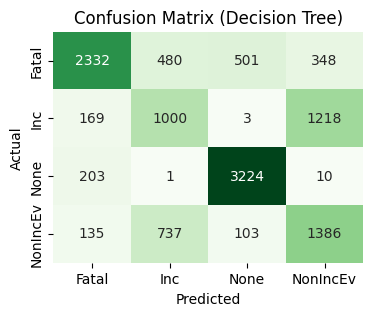

In [69]:
class_labels = ['Fatal', 'Inc', 'None', 'NonIncEv']

cm = results_df.loc[results_df["Model"] == 'Decision Tree', 'Confusion Matrix'].values[0]

plt.figure(figsize=(4, 3))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Greens', 
            xticklabels=class_labels, 
            yticklabels=class_labels, 
            cbar=False)
plt.xticks(rotation=0)
plt.yticks(rotation=90)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

Analysis of the decision tree's confusion matrix shows the model performed best at classifying fatal and no injury classes in the dataset. The model however fails to separate incapacitating and Non-evident incapacitating injuries. Since these are both similar levels of injury this is not entirely unexpected. Overall, while the Decision Tree performs well in separating clearly distinct classes, it demonstrates room for improvement in differentiating closely related ones. More complex models, potentially leveraging additional dataset features, may improve the model’s ability to delineate between these subtle classes.

# Bacteria

## EDA

In [10]:
fitting_results_raw = pd.read_csv("fitting-results.csv")

fitting_results_raw.shape

(19992, 9)

The dataset is quite 'tall'. Containing quite a lot of instances for training but with few features. There are 4 predictor columns and 4 targets. So feature reduction with PCA/RFB aren't necessary.

In [11]:
print("Missing Values:")
fitting_results_raw.isnull().sum()

Missing Values:


n_cyanos    0
co2         0
light       0
SucRatio    0
Nsample     0
a           0
mu          0
tau         0
a0          0
dtype: int64

There are no missing values so data imputation should not be required during preparation.

In [12]:

column_classification = pd.DataFrame({
    'Column Name': fitting_results_raw.columns,
    'Data Type': fitting_results_raw.dtypes,
    'Category': fitting_results_raw.apply(classify_columns)
})

type_count = column_classification['Category'].value_counts()

print(type_count)

Category
Quantitative    9
Name: count, dtype: int64


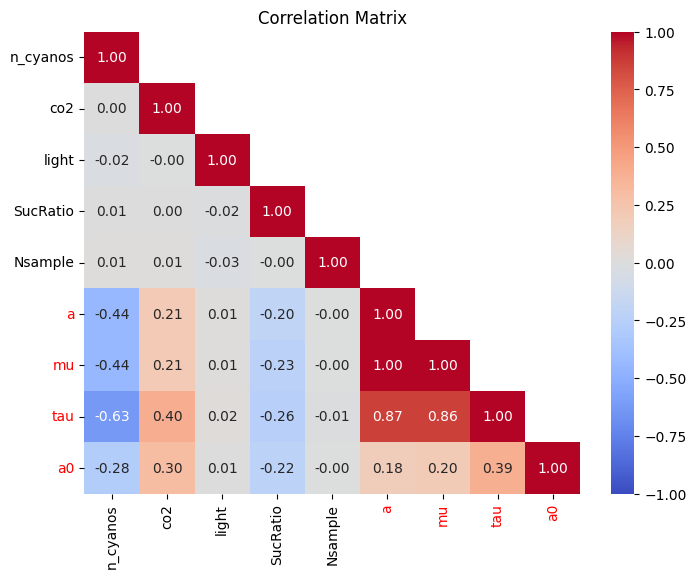

In [13]:
corr_matrix = fitting_results_raw.corr()

plt.figure(figsize=(8, 6))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(corr_matrix, 
            annot=True, 
            cmap="coolwarm", 
            fmt=".2f",
            mask=mask,
            vmax = 1,
            vmin = -1)
plt.title("Correlation Matrix")

ax = plt.gca()
specific_labels = {'a', 'mu', 'tau', 'a0'}

for label in ax.get_xticklabels():
    if label.get_text() in specific_labels:
        label.set_color("red")  

for label in ax.get_yticklabels():
    if label.get_text() in specific_labels:
        label.set_color("red")
plt.show()

As expected sample number, being and ID column, has no correlation with growth of bacteria. There does appear to be some correlation between our target variables and n_cyanos, co2, and SucRatio, which could prove helpful for predictions. Light appears to have no influence on any target variables.

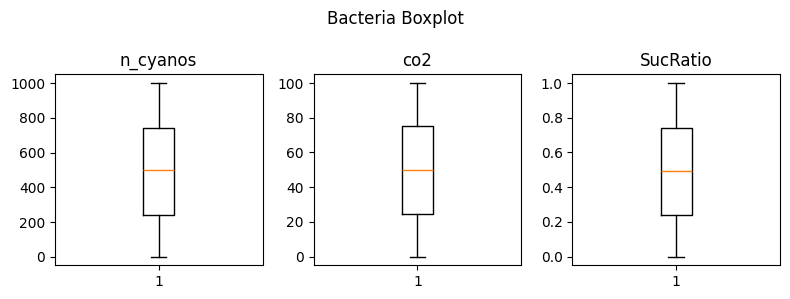

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

axes[0].boxplot(fitting_results_raw['n_cyanos'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[0].set_title('n_cyanos')
axes[1].boxplot(fitting_results_raw['co2'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[1].set_title('co2')
axes[2].boxplot(fitting_results_raw['SucRatio'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[2].set_title('SucRatio')

fig.suptitle("Bacteria Boxplot")
plt.tight_layout()

The predictive variables of the dataset follow a 'flat' distribution. There are no outlier samples from these.

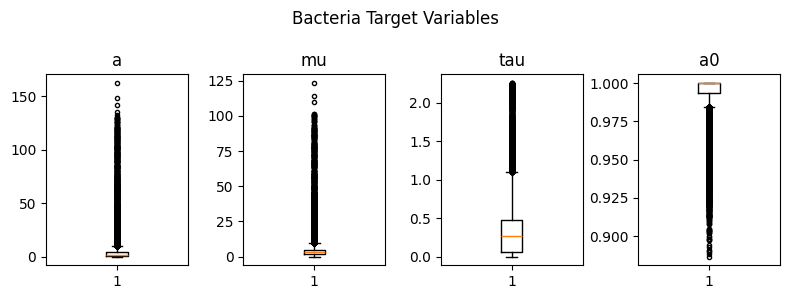

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(8, 3))

axes[0].boxplot(fitting_results_raw['a'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[0].set_title('a')
axes[1].boxplot(fitting_results_raw['mu'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[1].set_title('mu')
axes[2].boxplot(fitting_results_raw['tau'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[2].set_title('tau')
axes[3].boxplot(fitting_results_raw['a0'], flierprops=dict(marker='o', markersize=3, color='black'))
axes[3].set_title('a0')

fig.suptitle("Bacteria Target Variables")
plt.tight_layout()

The dataset's target variables contain many outliers, values which fall away from the maximum IQR of the boxplots. These will have to be addressed during pipeline creation.

## Data Preparation

The 'Nsample' id column has been dropped as it provides no prediction power and may skew model predictions

In [16]:
fitting_results_clean = fitting_results_raw.drop(columns=['Nsample'])

Two pre-processing pipelines have been created. Both scale the data to ensure that each variable has an equal impact on model parameters during training. Outliers have been removed for the training set in one. To assess outlier removals performance a pre processing pipeline which does not remove outliers has been implemented. Outlier removal only occurs on the training set.

Outliers were removed from the dataset with my YBasedOutlierRemover function. This removes outliers from X and Y after finding out which indices contain outliers from their Y label data.

In [17]:
class YBasedOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, target_columns, multiplier=1.5):
        self.target_columns = target_columns
        self.multiplier = multiplier
        self.outlier_indices_ = set()

    def fit(self, X, y):
        y_df = pd.DataFrame(y, columns=self.target_columns)
        for col in self.target_columns:
            # Calculate IQR upper and lower bound
            Q1 = y_df[col].quantile(0.25)
            Q3 = y_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.multiplier * IQR
            upper_bound = Q3 + self.multiplier * IQR

            # Identify outliers and update indices
            outliers = y_df[(y_df[col] < lower_bound) | (y_df[col] > upper_bound)].index
            self.outlier_indices_.update(outliers)

        return self

    def transform(self, X, y):
        # Generate mask of dataframe with values out IQR being true
        mask = ~np.isin(np.arange(len(y)), list(self.outlier_indices_))

        # Apply mask to both dataframe and return
        X_clean = X[mask].reset_index(drop=True)
        y_clean = pd.DataFrame(y, columns=self.target_columns).iloc[mask].reset_index(drop=True)
        return X_clean, y_clean

Data was split into training and testing (validation is done automatically by GridSearchCV), with labels being kept separate from features. 
The 64/16/20 training, validation, and test splits this results in leaves enough data for training and hyper-parameter tuning. Along side a sufficient test set.

In [18]:
features = ['n_cyanos', 'co2', 'light', 'SucRatio']
targets = ['a', 'mu', 'tau', 'a0']

X_data = fitting_results_clean[features]
y_data = fitting_results_clean[targets]

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)


## Pipelines

### Linear Regression (Outlier Removal)

A pipeline was created which uses cross validation to tune hyper parameters. X data is scaled appropriately and has outliers removed, using the target data. Outliers were not removed from the testing data so that the models performance were based on real data. Sci-kit learns automatic validation splits were based on the train set so had outliers removed. However, the small amount of data leakage this causes should not dramatically throw off any results.


--- Training Model for Target: a ---
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Cross-Validation Score (Neg MSE): -130.0790775396434
Test R^2 for a: 0.283
Test NMSE for a: 0.717

--- Training Model for Target: mu ---
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Cross-Validation Score (Neg MSE): -68.87081128925446
Test R^2 for mu: 0.297
Test NMSE for mu: 0.703

--- Training Model for Target: tau ---
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Cross-Validation Score (Neg MSE): -0.0673371567530896
Test R^2 for tau: 0.622
Test NMSE for tau: 0.378

--- Training Model for Target: a0 ---
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Cross-Validation Score (Neg MSE): -0.0002291325273320099
Test R^2 for a0: 0.215
Test NMSE for a0: 0.785


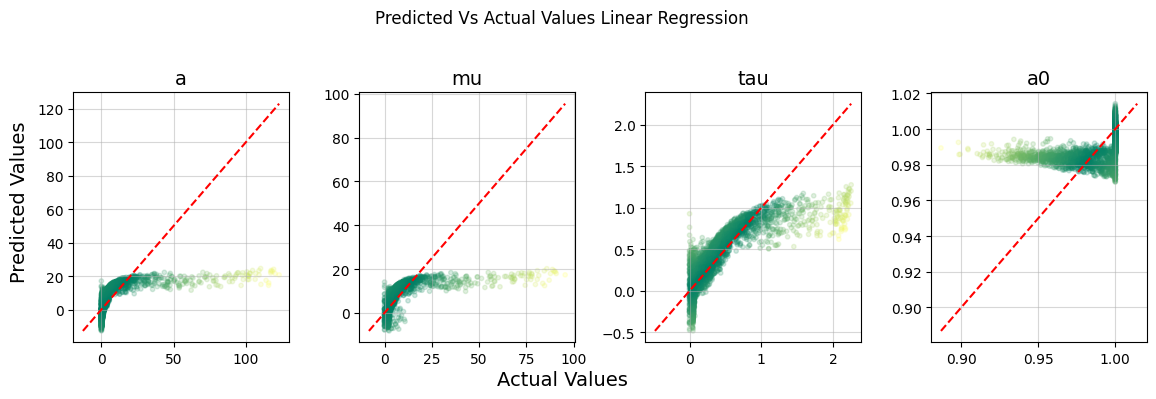

In [19]:
results_list = []
targets = ['a', 'mu', 'tau', 'a0']

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
ax = 0

for curr_target in targets:
    print(f"\n--- Training Model for Target: {curr_target} ---")
    
    outlier_remover = YBasedOutlierRemover(target_columns=targets, multiplier=1.5)
    outlier_remover.fit(X_train, y_train)
    X_train_clean, y_train_clean = outlier_remover.transform(X_train, y_train)
    
    pipeline_lr = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression())
    ])
    
    param_grid_lr = {
        'regressor__fit_intercept': [True, False]
    }
    
    grid_search_lr = GridSearchCV(
        estimator=pipeline_lr,
        param_grid=param_grid_lr,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_lr.fit(X_train_clean, y_train_clean[curr_target])
    print("Best Cross-Validation Score (Neg MSE):", grid_search_lr.best_score_)
    
    best_pipeline_lr = grid_search_lr.best_estimator_
    y_test_pred = best_pipeline_lr.predict(X_test)
    test_mse = mean_squared_error(y_test[curr_target], y_test_pred)
    test_r2 = r2_score(y_test[curr_target], y_test_pred)

    test_nmse = test_mse/ np.var(y_test[curr_target])
    
    print(f"Test R^2 for {curr_target}: {test_r2:.3f}")
    print(f"Test NMSE for {curr_target}: {test_nmse:.3f}")

    results_list.append({
        'model': 'Linear Regression',
        'target': curr_target,
        'best_params': grid_search_lr.best_params_,
        'best_cv_score': grid_search_lr.best_score_,
        'test_r2': test_r2,
        'test_nmse': test_nmse
    })
    
    # Predicted vs actual plotting
    distances = np.abs(y_test[curr_target] - y_test_pred)
    
    norm = Normalize(vmin=distances.min(), vmax=distances.max())
    cmap = plt.cm.summer

    axes[ax].scatter(y_test[curr_target], y_test_pred, alpha=0.2, s=10, c=distances, cmap=cmap)

    min_val = min(min(y_test[curr_target]), min(y_test_pred))
    max_val = max(max(y_test[curr_target]), max(y_test_pred))

    axes[ax].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[ax].set_title(f"{curr_target}", fontsize=14)
    axes[ax].grid(True, alpha = 0.5)

    ax = ax + 1

fig.text(0.5, 0.04, 'Actual Values', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Predicted Values', va='center', rotation='vertical', fontsize=14)
fig.suptitle("Predicted Vs Actual Values Linear Regression")
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])


### SVR (Linear)

To if a model softer on outliers would perform well a linear SVR was trained. The data was scaled with MinMaxScaler, placing the predictor features on a 0-1 scale. This helps with the models stability and increases speed of convergence due to distances between features being larger and equal. Outlier removal wasn't done, as SVR is more robust to outliers with use of the 'epsilon tube'. The extra data retained through this approach may help prediction especially on predictor variables which lies far away from usual distribution.

Training for a
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/jackwestmoreland/.virtualenvs/MachineLearning/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'svr__C': 10, 'svr__epsilon': 1, 'svr__kernel': 'linear'}
Best CV Score: -157.46464173514227
Test R^2 Score: 0.11566307146247923
Test NMSE: 0.8841157890205071
Training for mu
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 1, 'svr__kernel': 'linear'}
Best CV Score: -81.32105166918635
Test R^2 Score: 0.15326637113545083
Test NMSE: 0.8465218925232477
Training for tau
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__kernel': 'linear'}
Best CV Score: -0.07493517310516515
Test R^2 Score: 0.5730891985702165
Test NMSE: 0.42680404704082886
Training for a0
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'svr__C': 1, 'svr__epsilon': 0.01, 'svr__kernel': 'linear'}
Best CV Score: -0.00024024398356005256
Test R^2 Score: 0.1816583967142602
Test NMSE: 0.8181369667257784


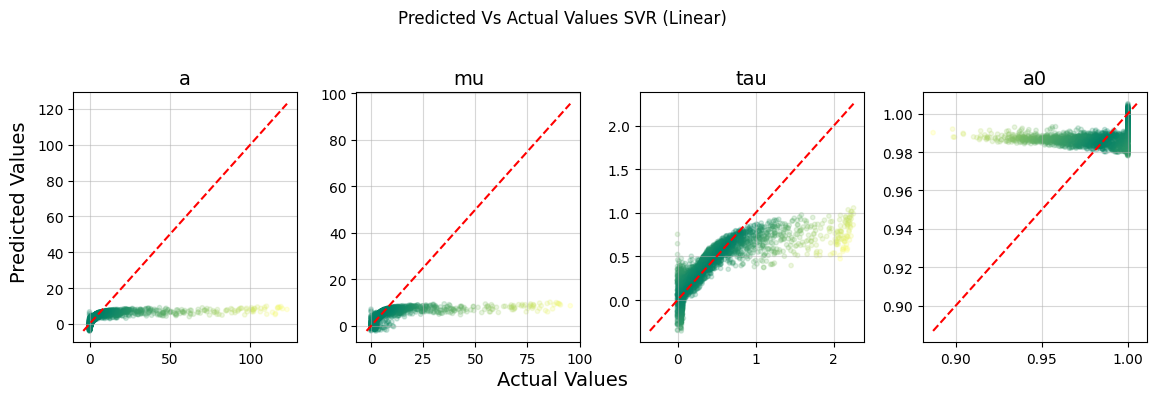

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
ax = 0

for curr_target in targets:

    print('===========================')
    print(f'Training for {curr_target}')
    print('===========================')


    X = fitting_results_raw[['SucRatio', 'co2', 'light', 'n_cyanos']]
    y = fitting_results_raw[curr_target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42
    )
        
    pipeline_svr_lin = Pipeline([
        ('scaler', MinMaxScaler()),  # or StandardScaler()
        ('svr', SVR())
    ])

    param_grid_svr_lin = {
        'svr__kernel': ['linear'],
        'svr__C': [0.1, 1, 10],
        'svr__epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1]
    }

    grid_search_svr_lin = GridSearchCV(
        estimator=pipeline_svr_lin, 
        param_grid=param_grid_svr_lin, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose = 1
    )

    grid_search_svr_lin.fit(X_train, y_train)

    print("Best Parameters:", grid_search_svr_lin.best_params_)
    print("Best CV Score:", grid_search_svr_lin.best_score_)

    best_model_svr_lin = grid_search_svr_lin.best_estimator_
    y_predict = best_model_svr_lin.predict(X_test)

    r_squared = r2_score(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)

    print(f"Test R^2 Score: {r_squared}")
    print(f"Test NMSE: {mse / np.var(y_test, ddof=1)}")

    results_list.append({
        'model': 'SVR (linear)',
        'target': curr_target,
        'best_params': grid_search_svr_lin.best_params_,
        'best_cv_score': grid_search_svr_lin.best_score_,
        'test_r2': r_squared,
        'test_nmse': mse / np.var(y_test, ddof=1)
    })

    # Predicted vs actual plotting
    distances = np.abs(y_test - y_predict)
    norm = Normalize(vmin=distances.min(), vmax=distances.max())
    cmap = plt.cm.summer

    axes[ax].scatter(y_test, y_predict, alpha=0.2, s=10, c=distances, cmap=cmap)

    min_val = min(min(y_test), min(y_predict))
    max_val = max(max(y_test), max(y_predict))

    axes[ax].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[ax].set_title(f"{curr_target}", fontsize=14)
    axes[ax].grid(True, alpha = 0.5)

    ax = ax + 1

fig.text(0.5, 0.04, 'Actual Values', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Predicted Values', va='center', rotation='vertical', fontsize=14)
fig.suptitle("Predicted Vs Actual Values SVR (Linear)")
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig('PVASVRLIN.png')


### SVR (rbf)

Due to earlier data analysis only showing relatively small linear correlation between features a rbf kernel svr model was trained. This will allow for non-linear relationships between the target and predictor variables to be used for target variables prediction. This achieved via the 'kernel trick' in which data is mapped to high dimensional space without explicitly calculating their position. The C parameter can also be tuned during hyper-parameter training to reduce or increase overfilling to the training set.

Training for a
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 1, 'svr__kernel': 'rbf'}
Best CV Score: -62.72506725615292
Test R^2 Score: 0.6584232158024914
Test NMSE: 0.3414913686475717
Training for mu
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 1, 'svr__kernel': 'rbf'}
Best CV Score: -29.960574429228064
Test R^2 Score: 0.7004158853560933
Test NMSE: 0.2995091998865564
Training for tau
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__kernel': 'rbf'}
Best CV Score: -0.006488437636573023
Test R^2 Score: 0.9660730851929581
Test NMSE: 0.03391843095737775
Training for a0
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.001, 'svr__kernel': 'rbf'}
Best CV Score: -0.00012514666717213503
Test R^2 Score: 0.5812114981799941
Test NMSE: 0.4186

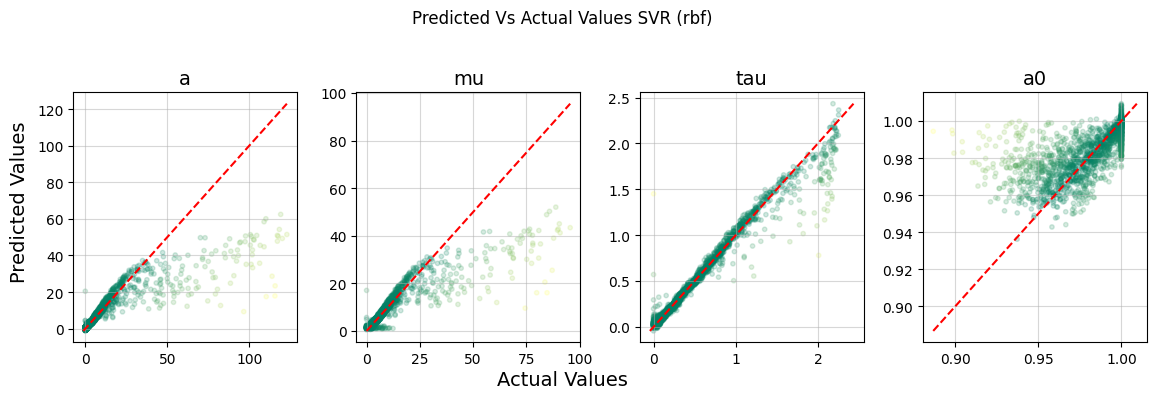

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
ax = 0

for curr_target in targets:

    print('===========================')
    print(f'Training for {curr_target}')
    print('===========================')

    X = fitting_results_raw[['SucRatio', 'co2', 'light', 'n_cyanos']]
    y = fitting_results_raw[curr_target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42
    )

    pipeline_svr_rbf = Pipeline([
        ('scaler', MinMaxScaler()),
        ('svr', SVR())
    ])

    param_grid_svr_rbf = {
        'svr__kernel': ['rbf'],
        'svr__C': [0.1, 1, 10],
        'svr__epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1]
    }

    grid_search_svr_rbf = GridSearchCV(
        estimator=pipeline_svr_rbf, 
        param_grid=param_grid_svr_rbf, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search_svr_rbf.fit(X_train, y_train)

    print("Best Parameters:", grid_search_svr_rbf.best_params_)
    print("Best CV Score:", grid_search_svr_rbf.best_score_)

    best_model_svr_rbf = grid_search_svr_rbf.best_estimator_
    y_predict = best_model_svr_rbf.predict(X_test)

    r_squared = r2_score(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    print(f"Test R^2 Score: {r_squared}")
    print(f"Test NMSE: {mse / np.var(y_test, ddof=1)}")

    results_list.append({
        'model': 'SVR (rbf)',
        'target': curr_target,
        'best_params': grid_search_svr_rbf.best_params_,
        'best_cv_score': grid_search_svr_rbf.best_score_,
        'test_r2': r_squared,
        'test_nmse': mse / np.var(y_test, ddof=1)
    })

    # Predicted vs actual plotting
    distances = np.abs(y_test - y_predict)
    norm = Normalize(vmin=distances.min(), vmax=distances.max())
    cmap = plt.cm.summer

    axes[ax].scatter(y_test, y_predict, alpha=0.2, s=10, c=distances, cmap=cmap)

    min_val = min(min(y_test), min(y_predict))
    max_val = max(max(y_test), max(y_predict))

    axes[ax].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[ax].set_title(f"{curr_target}", fontsize=14)
    axes[ax].grid(True, alpha = 0.5)

    ax = ax + 1

fig.text(0.5, 0.04, 'Actual Values', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Predicted Values', va='center', rotation='vertical', fontsize=14)
fig.suptitle("Predicted Vs Actual Values SVR (rbf)")
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig('PVARBF.png')


### SVR (Poly)

A third SVR using a polynomial kernel was used. Following a similar pipeline structure to the previous SVR models. To reduce complexity of this model, low degree and C values where chosen for hyper parameter tuning. With a degree of 2 quadratic relationships between data points are considered, this extra complexity could be captured to show more complex interactions between our features.
Additionally target variables with extremely low variance had scaling applied, this magnifies the signal of the data for the model to learn, and reduces the importance the noise has on the dataset and therefore over fitting to said noise.

Training for a
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'regressor__svr__C': 0.1, 'regressor__svr__coef0': 1.0, 'regressor__svr__degree': 2, 'regressor__svr__epsilon': 0.1, 'regressor__svr__kernel': 'poly'}
Best CV Score: -125.31091007055609
Test R^2 Score: 0.3004797654625183
Test NMSE: 0.6993453107478999
Training for mu
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'regressor__svr__C': 0.1, 'regressor__svr__coef0': 1.0, 'regressor__svr__degree': 2, 'regressor__svr__epsilon': 0.1, 'regressor__svr__kernel': 'poly'}
Best CV Score: -65.86479252977087
Test R^2 Score: 0.3155558728743145
Test NMSE: 0.684272973305449
Training for tau
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'regressor__svr__C': 0.1, 'regressor__svr__coef0': 1.0, 'regressor__svr__degree': 2, 'regressor__svr__epsilon': 0.1, 'regressor__svr__kernel': 'poly'}
Best CV Score: -0.03194864230325731
Test R^2 Score: 0.8217916

/Users/jackwestmoreland/.virtualenvs/MachineLearning/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'regressor__svr__C': 5, 'regressor__svr__coef0': 1.0, 'regressor__svr__degree': 2, 'regressor__svr__epsilon': 0.1, 'regressor__svr__kernel': 'poly'}
Best CV Score: -0.00023097135575538582
Test R^2 Score: 0.2192312301639533
Test NMSE: 0.7805735288333371


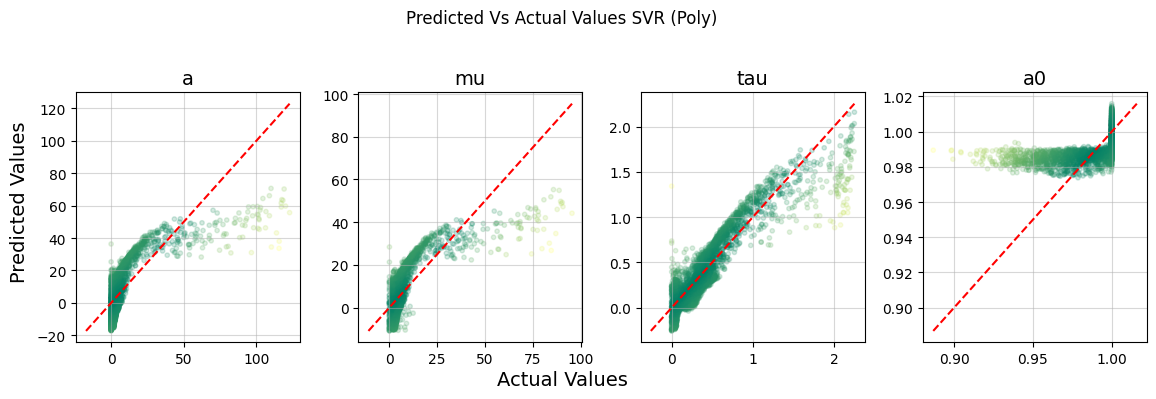

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
ax = 0
from sklearn.compose import TransformedTargetRegressor


for curr_target in targets:
    print('===========================')
    print(f'Training for {curr_target}')
    print('===========================')

    X = fitting_results_raw[['SucRatio', 'co2', 'light', 'n_cyanos']]
    y = fitting_results_raw[curr_target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42
    )

    svr_poly = Pipeline([
        ('scaler', MinMaxScaler()),
        ('svr', SVR())
    ])

    pipeline_svr_poly = TransformedTargetRegressor(
        regressor=svr_poly, 
        transformer=MinMaxScaler()
    )

    param_grid_svr_poly = {
       'regressor__svr__kernel': ['poly'],  # Nested param for SVR inside pipeline
        'regressor__svr__C': [0.1, 1, 5],
        'regressor__svr__epsilon': [1e-1, 1],
        'regressor__svr__degree': [1, 2],
        'regressor__svr__coef0': [1.0, 10.0]
    }
    
    grid_search_svr_poly = GridSearchCV(
        estimator=pipeline_svr_poly, 
        param_grid=param_grid_svr_poly, 
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    grid_search_svr_poly.fit(X_train, y_train)

    print("Best Parameters:", grid_search_svr_poly.best_params_)
    print("Best CV Score:", grid_search_svr_poly.best_score_)

    best_model_svr_poly = grid_search_svr_poly.best_estimator_
    y_predict = best_model_svr_poly.predict(X_test)

    r_squared = r2_score(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    print(f"Test R^2 Score: {r_squared}")
    print(f"Test NMSE: {mse / np.var(y_test, ddof=1)}")

    results_list.append({
        'model': 'SVR (Poly)',
        'target': curr_target,
        'best_params': grid_search_svr_poly.best_params_,
        'best_cv_score': grid_search_svr_poly.best_score_,
        'test_r2': r_squared,
        'test_nmse': mse / np.var(y_test, ddof=1)
    })

    # Predicted vs actual plotting
    distances = np.abs(y_test - y_predict)
    norm = Normalize(vmin=distances.min(), vmax=distances.max())
    cmap = plt.cm.summer

    axes[ax].scatter(y_test, y_predict, alpha=0.2, s=10, c=distances, cmap=cmap)

    min_val = min(min(y_test), min(y_predict))
    max_val = max(max(y_test), max(y_predict))

    axes[ax].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[ax].set_title(f"{curr_target}", fontsize=14)
    axes[ax].grid(True, alpha = 0.5)

    ax = ax + 1

fig.text(0.5, 0.04, 'Actual Values', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Predicted Values', va='center', rotation='vertical', fontsize=14)
fig.suptitle("Predicted Vs Actual Values SVR (Poly)")
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

In [23]:
results_regression_df = pd.DataFrame(results_list)

## Results

In [31]:
html_table = results_regression_df[['model', 'target', 'test_r2', 'test_nmse']].to_html(index=False)
display(HTML(html_table))

model,target,test_r2,test_nmse
Linear Regression,a,0.283329,0.716671
Linear Regression,mu,0.296979,0.703021
Linear Regression,tau,0.622359,0.377641
Linear Regression,a0,0.214981,0.785019
SVR (linear),a,0.115663,0.884116
SVR (linear),mu,0.153266,0.846522
SVR (linear),tau,0.573089,0.426804
SVR (linear),a0,0.181658,0.818137
SVR (rbf),a,0.658423,0.341491
SVR (rbf),mu,0.700416,0.299509


For each pipeline two metrics have been used to evaluate their performance on the dataset. R^2 is a measure of the models prediction power as a percentage of variance of the target class it is able to explain. MSE is a measure of the average difference between the prediction and ground truth of the target. As target variables are on vastly different scaled the MSE of each model has been normalized so that performance across targets can be compared.

The worst scoring model across all metrics and targets was the SVR (Linear). This model only saw decent performance on 'tau' which was previously shown to have linear correlation. It's poor performance on other targets imply that many of the target variables do not have a linear relationship with the predictor values. Furthermore, the introduction of epsilon (insensitive loss function) may have caused the trained model to be too forgiving of errors when compared to linear regression which preformed marginally better.

The best scoring models were SVR (rbf) and SVR (poly). These models are able to find and fit to non linear relationships in data by using the kernel trick. RBF has outperformed all other methods for all targets. The poly kernel may have performed better if a higher polynomial factor was chosen, allowing non-quadratic correlations to be observed, however this drastically increased compute time for the model.

![image](PVARBF.png)

The above graph shows and model scores prove that the SVR (rbf) pipeline performed well on the dataset, being able to give accurate predictions for all values of tau, and the vast majority of values for 'a' and 'mu'. Unfortunately the model still struggles with 'a0', likely due to this variables extremely low variance hindering the ability for models to find trends in the feature.


# NLP

## EDA

In [2]:
news_raw_df = pd.read_csv('news.csv', sep='\t')
print(f"Missing values: {news_raw_df.isnull().sum().sum()}")

Missing values: 0


There are no missing values in the dataset.

In [3]:
news_raw_df['normalized_text'] = news_raw_df['story'].str.strip().str.lower()

news_df = news_raw_df.drop_duplicates(subset='normalized_text', keep='first').drop(columns=['normalized_text'])

print(f"Original DataFrame shape: {news_raw_df.shape}")
print(f"Cleaned DataFrame shape: {news_df.shape}")


Original DataFrame shape: (2225, 2)
Cleaned DataFrame shape: (2091, 1)


Duplicate entries were removed.

## Preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

During preprocessing stories had their stop words removed alongside extra spaces and non word characters. This is vital to reduce the noise in the dataset, distilling each sentence down to their semantic meaning which models can process. The tokenized words were then 'lemonized' replacing them with its root concept, further ensuring words are distilled down to their base meanings.

In [56]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

news_df['processed_text'] = news_df['story'].apply(preprocess_text)

In [57]:
preprocess_text('This is a test of my pre-processing pipeline, i sure hope this works!')

'test pre processing pipeline sure hope work'

## Pipelines

### Bag of Words

A bag of words vectorize was used, this method represents natural language as vectors of unique words. (26172 for this dataset) storing the count of each word for each instance of a story. This was done due to its computational efficiency when compared to other vectorization methods.

In [7]:
vectorizer_bow = CountVectorizer()

X_bow = vectorizer_bow.fit_transform(news_df['processed_text'])

X_bow.shape

(2091, 26172)

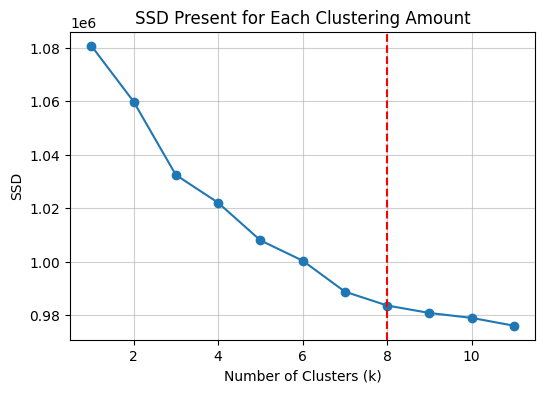

In [8]:
inertia = []
k_values = range(1, 12)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_bow)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertia, marker='o')
plt.title('SSD Present for Each Clustering Amount')
plt.xlabel('Number of Clusters (k)')
plt.axvline(x=8, color='r', linestyle='--',)
plt.ylabel('SSD')
plt.grid(alpha=0.6)
plt.show()


K-means clustering has been performed using 8 clusters. which was chosen as there is a drop off in SSD reduction after this point, showing that additional clusters become similar.

In [9]:
optimal_k = 8
kmeans_BoW = KMeans(n_clusters=optimal_k, random_state=42)
news_df['cluster_BoW'] = kmeans_BoW.fit_predict(X_bow)

In [52]:
cluster_centers = kmeans_BoW.cluster_centers_
feature_names = vectorizer_bow.get_feature_names_out()
cluster_counts = news_df['cluster_BoW'].value_counts().sort_index()

cluster_data = []

for cluster_idx, cluster_center in enumerate(cluster_centers):

    top_indices = cluster_center.argsort()[-6:][::-1]  # Get top 6 words
    top_words = [feature_names[i] for i in top_indices]
    
    # Get number of entries in the cluster
    story_count = cluster_counts[cluster_idx]

    cluster_data.append({
        "Method": 'BoW',
        "Cluster": cluster_idx,
        "Story Count": story_count,
        "Top Words": ", ".join(top_words)
    })


### TF-IDF

TF-IDF has also been used for word vectorization. This method evaluates the importance of each word as a relation between its use in each story and it's frequency in the whole dataset. This punished words for being common making more meaningful words count more towards that stories vector.

In [11]:
vectorizer_tfidf = TfidfVectorizer()

X_tfidf = vectorizer_tfidf.fit_transform(news_df['processed_text'])

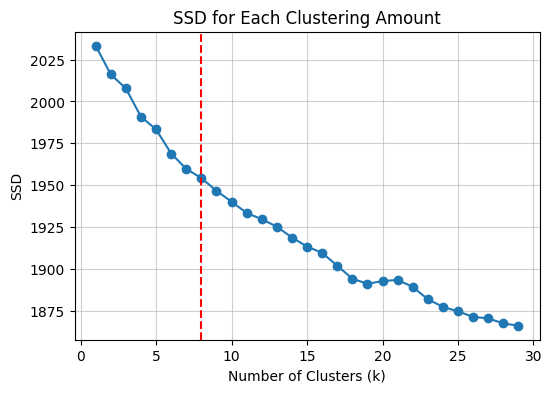

In [12]:
inertia = []
k_values = range(1, 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_values, inertia, marker='o')
plt.title('SSD for Each Clustering Amount')
plt.xlabel('Number of Clusters (k)')
plt.axvline(x=8, color='r', linestyle='--',)
plt.ylabel('SSD')
plt.grid(alpha=0.6)
plt.show()

Cluster SSD analysis does not show any clear 'elbow' where more clusters do not become similar. Therefore the same k=8 was used so that results could be more interpretable and comparable to BoW.

In [13]:
optimal_k = 8
kmeans_tfidf = KMeans(n_clusters=optimal_k, random_state=42)
news_df['cluster_TF-IDF'] = kmeans_tfidf.fit_predict(X_tfidf)

In [53]:
cluster_centers = kmeans_tfidf.cluster_centers_
feature_names = vectorizer_tfidf.get_feature_names_out()
cluster_counts = news_df['cluster_TF-IDF'].value_counts().sort_index()

for cluster_idx, cluster_center in enumerate(cluster_centers):
    top_indices = cluster_center.argsort()[-6:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    
    story_count = cluster_counts[cluster_idx]
    
    cluster_data.append({
        "Method": 'TF-IDF',
        "Cluster": cluster_idx,
        "Story Count": story_count,
        "Top Words": ", ".join(top_words)
    })

cluster_df = pd.DataFrame(cluster_data)

#### PCA Plot

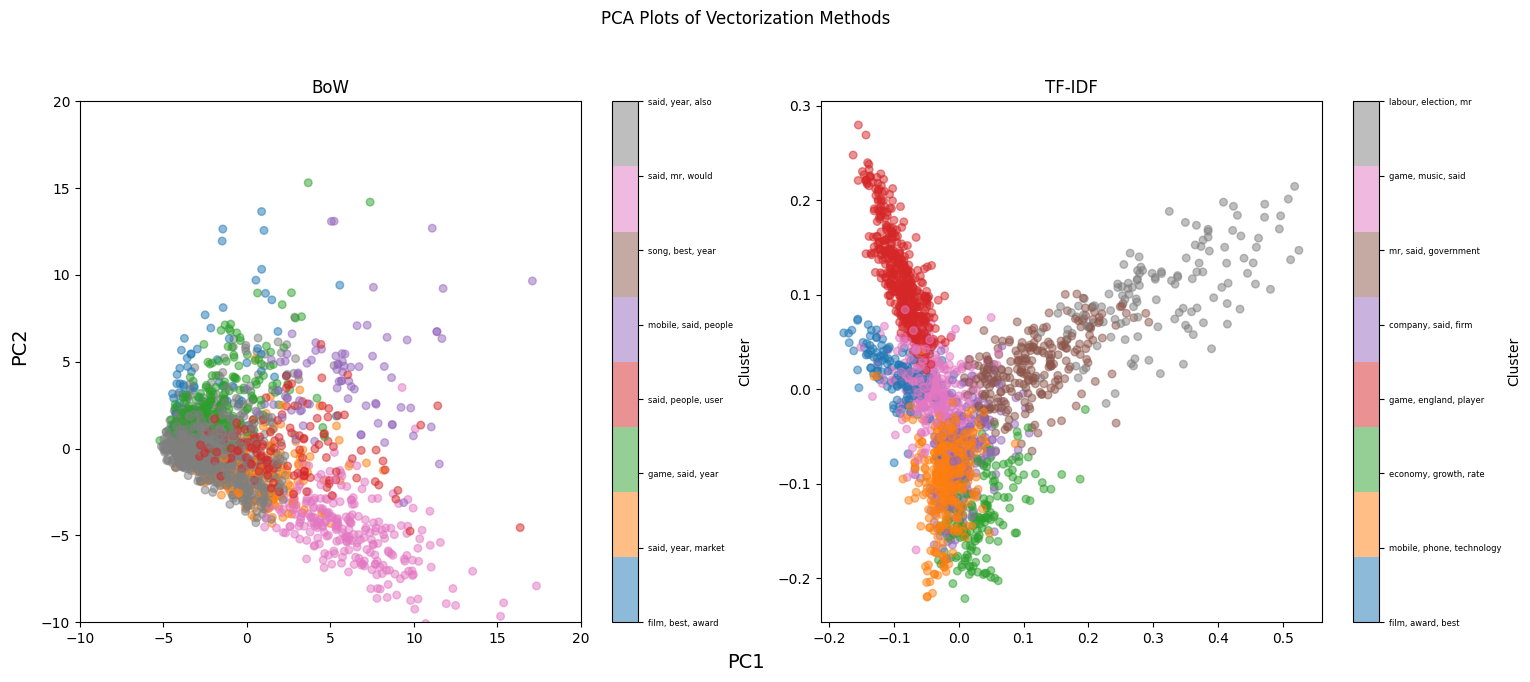

In [49]:
# Top three words for each cluster
top_words_bow = {
    0: "film, best, award",
    1: "said, year, market",
    2: "game, said, year",
    3: "said, people, user",
    4: "mobile, said, people",
    5: "song, best, year",
    6: "said, mr, would",
    7: "said, year, also"
}

top_words_tfidf = {
    0: "film, award, best",
    1: "mobile, phone, technology",
    2: "economy, growth, rate",
    3: "game, england, player",
    4: "company, said, firm",
    5: "mr, said, government",
    6: "game, music, said",
    7: "labour, election, mr"
}

# PCA for BoW
pca_bow = PCA(n_components=2, random_state=42)
X_bow_pca = pca_bow.fit_transform(X_bow.toarray())

# PCA for TF-IDF
pca_tfidf = PCA(n_components=2, random_state=42)
X_tfidf_pca = pca_tfidf.fit_transform(X_tfidf.toarray())

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# BoW Plot
#create colors
num_clusters = len(top_words_bow)  # Number of clusters
cmap = ListedColormap(plt.cm.tab10.colors[:num_clusters])

scatter_bow = ax[0].scatter(
    X_bow_pca[:, 0], X_bow_pca[:, 1],
    c=news_df['cluster_BoW'], cmap=cmap, s=30, alpha=0.5
)
ax[0].set_title('BoW')
ax[0].set_xlim(left=-10, right=20)
ax[0].set_ylim(bottom=-10, top=20)
cbar_bow = plt.colorbar(scatter_bow, ax=ax[0], label='Cluster')
cbar_bow.set_ticks(list(top_words_bow.keys()))
cbar_bow.set_ticklabels([top_words_bow[i] for i in top_words_bow.keys()])
cbar_bow.ax.tick_params(labelsize=6)

# TF-IDF Plot
#create colors
num_clusters = len(top_words_tfidf)
cmap = ListedColormap(plt.cm.tab10.colors[:num_clusters])


scatter_tfidf = ax[1].scatter(
    X_tfidf_pca[:, 0], X_tfidf_pca[:, 1],
    c=news_df['cluster_TF-IDF'], cmap=cmap, s=30, alpha=0.5
)
ax[1].set_title('TF-IDF')
cbar_tfidf = plt.colorbar(scatter_tfidf, ax=ax[1], label='Cluster')
cbar_tfidf.set_ticks(list(top_words_tfidf.keys()))
cbar_tfidf.set_ticklabels([top_words_tfidf[i] for i in top_words_tfidf.keys()])
cbar_tfidf.ax.tick_params(labelsize=6)

fig.text(0.5, 0.04, 'PC1', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'PC2', va='center', rotation='vertical', fontsize=14)
plt.suptitle("PCA Plots of Vectorization Methods")
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.savefig("clusteringAnalysis.png")

## Results

In [54]:

html_table = cluster_df.to_html(index=False)
display(HTML(html_table))

Method,Cluster,Story Count,Top Words
BoW,0,71,"film, best, award, said, year, actor"
BoW,1,372,"said, year, market, company, would, firm"
BoW,2,214,"game, said, year, first, england, time"
BoW,3,129,"said, people, user, net, site, software"
BoW,4,81,"mobile, said, people, phone, technology, game"
BoW,5,1,"song, best, year, 25, angel, music"
BoW,6,258,"said, mr, would, labour, government, party"
BoW,7,965,"said, year, also, one, would, new"
TF-IDF,0,155,"film, award, best, oscar, actor, festival"
TF-IDF,1,276,"mobile, phone, technology, people, user, said"


Analysis of the eight clusters derived from both vectorization methods show clear distinctions in performance. TF-IDF seems to have performed better with there being less repeat words such as 'said' as top words of each cluster. Whereas BoW which does not account for the prevalence of the word in the whole dataset when deciding its 'importance' has many words which do not reveal what is being discussed by articles in each cluster. Additionally BoW has many outlier values for some clusters and a cluster of one story relating to Robbie Williams, which is not a broad enough category for clustering. Analysis of the spread of each cluster across PC1 and PC2 shown below shows that TF-IDF has also perfumed better at separating clusters whereas BoW has left many clusters sharing similar PC space. 

![image](clusteringAnalysis.png)

From analysis of the top words in the TF-IDF clusters i propose the following eight categories of news stories:
- 0: Film and actors
- 1: Technology
- 2: Economics
- 3: English football
- 4: General Business
- 5: General Politics
- 6: Music
- 7: Election politics


## References

[1] - John, G.H., Kohavi, R. and Pfleger, K. (1994) ‘Irrelevant features and the subset selection problem’, Machine Learning Proceedings 1994, pp. 121–129. doi:10.1016/b978-1-55860-335-6.50023-4. 
